In [1]:
#Run this notebook in the root directory of the project
%cd ../../../

/data/main/2024/GridCellsCond


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal,stats
import analysis_utils as a_utils
import sim_utils as s_hf
from scipy import signal
from scipy import ndimage
from scipy import stats
import seaborn as sns

In [3]:
def grid_props(inst_rates_reshaped,t=-1000):
    """Calculate 2D grid properties.
    Calculate the grid score, grid scale, and grid size from the 2D autocorrelation of firing rate map.

    Parameters:
    inst_rates_reshaped (numpy.ndarray): 3D array of reshaped instantaneous rates (cellxcellxtime).
    t (int): Time index to use for the calculation. Default is -1000.
    Returns:
    tuple: A tuple containing:
        - auto_corr (numpy.ndarray): Normalized 2D autocorrelation matrix.
        - grid_score (float): Grid score calculated from the autocorrelation matrix.
        - grid_scale (float): Median distance of the closest objects from the center.
        - grid_size (float): Median size of the grid cells.
    """

    auto_corr=signal.correlate2d(inst_rates_reshaped[:,:,t],inst_rates_reshaped[:,:,t],mode='full',boundary='wrap')
    auto_corr_mod = auto_corr.copy()
    auto_corr_mod[auto_corr_mod<(0.25*np.max(auto_corr))]=0
    features,nclusters=ndimage.label(auto_corr_mod,np.array([[1,1,1],[1,1,1],[1,1,1]]))
    obj = ndimage.find_objects(features)
    obj_dist_from_centre = np.zeros(nclusters)
    grid_size=[]
    center_object_idx = np.array([len(features)//2,len(features)//2])
    for i in range(nclusters):
        xdist=obj[i][0].stop-obj[i][0].start
        ydist=obj[i][1].stop-obj[i][1].start
        grid_size.append(np.mean([xdist,ydist]))
        row_cent_idx=int((obj[i][0].stop+obj[i][0].start)/2)
        col_cent_idx=int((obj[i][1].stop+obj[i][1].start)/2)
        obj_idx = np.array([row_cent_idx,col_cent_idx])
        obj_dist_from_centre[i]=np.linalg.norm(np.abs(obj_idx-center_object_idx))


    closest_obj_idx = np.argsort(obj_dist_from_centre)[1:7] #obj idx
    closest_obj = closest_obj_idx+1 #object number
    closest_obj_lims = np.zeros((len(closest_obj_idx),2,2))
    for i,idx in enumerate(closest_obj_idx):
        closest_obj_lims[i,:,0]=obj[idx][0].start,obj[idx][0].stop
        closest_obj_lims[i,:,1]=obj[idx][1].start,obj[idx][1].stop
    try:
        xmin,xmax=int(np.min(closest_obj_lims[:,:,0])),int(np.max(closest_obj_lims[:,:,0]))
        ymin,ymax=int(np.min(closest_obj_lims[:,:,1])),int(np.max(closest_obj_lims[:,:,1]))
    
        auto_corr_cropped=auto_corr_mod[xmin:xmax,ymin:ymax]
        rotations = [30,60,90,120,150]
        auto_corr_cropped_rotated = {}
        for i in rotations:
            auto_corr_cropped_rotated[i]=ndimage.rotate(auto_corr_cropped,i,reshape = False)

        correlations = {}
        for key,val in auto_corr_cropped_rotated.items():  
            correlations[key]=(stats.pearsonr(auto_corr_cropped.flatten(),val.flatten()))[0]

        min_corr = min(correlations[60],correlations[120])
        max_corr = max(correlations[30],correlations[90],correlations[150])
        grid_score= min_corr-max_corr
        grid_scale = np.median(np.sort(obj_dist_from_centre)[1:7])
        grid_size = np.median(grid_size)
        return  auto_corr/np.max(auto_corr),np.round(grid_score,2),round(grid_scale,2),round(grid_size,2)
    except:
        return auto_corr/np.max(auto_corr),np.nan,np.nan,np.nan


In [4]:
sim_id='VALD-ACVT-2D-S-s-2a'
params = s_hf.load_sim_params(sim_id)
stell_spks_l,intrnrn_spks_l = s_hf.load_spikes(sim_id)

In [5]:
n_per_sheet=params["N_per_sheet"]
sheet_to_plot=0
idx = np.full((4,2),n_per_sheet)*np.array([[0,1],[1,2],[2,3],[3,4]])
stell_spks_reshaped = a_utils.spks_to_rate_reshaped(stell_spks_l[idx[sheet_to_plot][0]:idx[sheet_to_plot][1]],params,win_size=100)

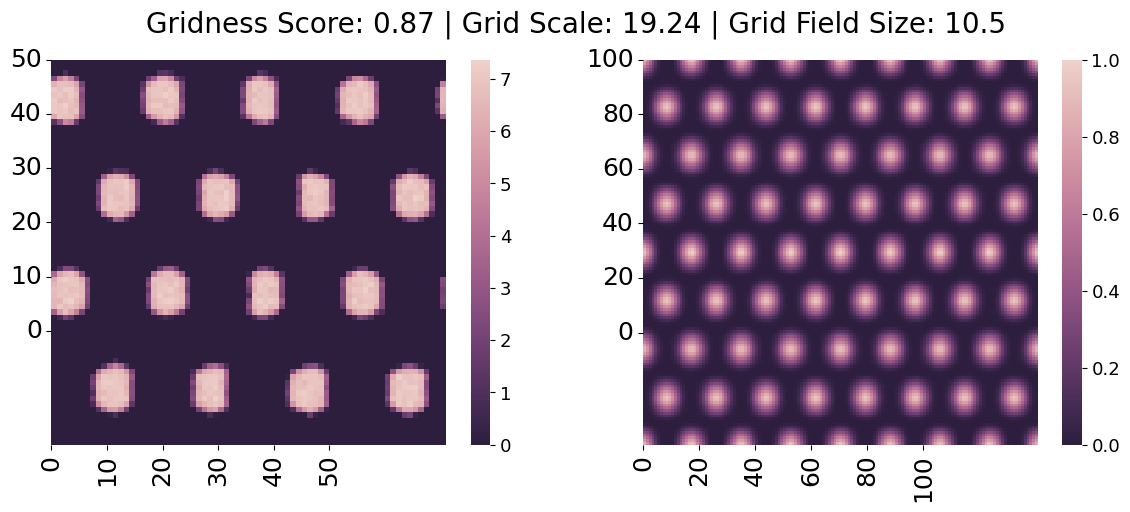

In [6]:
t_plot = 9500
auto_corr,grid_score,grid_scale,grid_size = grid_props(stell_spks_reshaped,t=t_plot)
fig,axs=plt.subplots(1,2,figsize=(14,5))
plot=sns.heatmap(stell_spks_reshaped[:,:,t_plot],cmap=sns.cubehelix_palette(as_cmap=True,reverse=True),linewidths=0,ax=axs[0])
axs[0].set(xticks=np.arange(0,51,10),xticklabels=np.arange(0,51,10),yticks=np.arange(0,51,10),yticklabels=np.arange(50,-1,-10))
plt.suptitle('Gridness Score: {} | Grid Scale: {} | Grid Field Size: {}'.format(grid_score,grid_scale,grid_size),fontsize=20)
cbar = plot.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
axs[0].tick_params(axis='both', which='major', labelsize=18)
plot=sns.heatmap(auto_corr,cmap=sns.cubehelix_palette(as_cmap=True,reverse=True),linewidths=0,ax=axs[1])
axs[1].set(xticks=np.arange(0,102,20),xticklabels=np.arange(0,102,20),yticks=np.arange(0,102,20),yticklabels=np.arange(100,-10,-20))
axs[1].tick_params(axis='both', which='major', labelsize=18)
cbar = plot.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.savefig('analysis/figures/Fig1/Fig1_C.svg')
plt.show()